In [2]:
from moarchiving.get_archive import get_archive
from moarchiving.moarchiving_utils import my_lexsort
from point_sampling import get_non_dominated_points

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import time
import numpy as np
import os
import copy

In [3]:
def plot_performance(f_name=None, plot_function="add", poly_degree=2, xlabel="Archive size",
                     ylabel="Time [s]", title="", logx=True, logy=True, colors=None):
    if f_name is None:
        f_names = os.listdir("test_results")
        f_names = [f for f in f_names if plot_function in f]
        f_names.sort()
        f_name = f_names[-1]

    df = pd.read_csv(f"test_results/{f_name}", index_col=0)
    print(df)

    if colors is None:
        colors = list(mcolors.TABLEAU_COLORS.keys())

    fig, ax = plt.subplots()

    for i, col in enumerate(df.columns):
        # make polynomial fit ignoring the nan values
        y = df[col]
        # shorten the data to the first nan value
        if np.isnan(y).any():
            idx = np.where(np.isnan(y))[0][0]
            y = y[:idx]
        x = df.index[:len(y)]

        # p = np.polyfit(x, y, poly_degree)
        ax.plot(x, y, '-o', label=col, color=colors[i])
        # ax.plot(x, np.polyval(p, x), '--', color=colors[i], alpha=0.4,
        #         label=f"{p[0]:.2E} x^{poly_degree} + O(x^{poly_degree-1})")

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")
    plt.legend()
    plt.grid()
    plt.title(f"{plot_function}: ({f_name[(len(plot_function)+1):-4]}) \n{title}")
    plt.show()


In [4]:
def save_results(data, index, n_dim, function):
    df = pd.DataFrame(data, index=index)
    date = time.strftime("%m%d-%H%M%S")
    df.to_csv(f"test_results/{function}_{n_dim}D_{date}.csv")

In [5]:
archive_sizes = [2 ** i for i in range(21)]

In [6]:
def test_add(test_archive_sizes, n_repeats=10, n_dim=3, time_limit=10):
    ref_point = [1] * n_dim

    times = []
    archive_sizes_tested = []
    print("TEST ADD", n_dim)
    print(f"{'num points':10} | {'one by one':10} |")

    for archive_size in test_archive_sizes:
        moa = [get_archive(get_non_dominated_points(archive_size, n_dim=n_dim), ref_point, n_obj=n_dim)
               for _ in range(n_repeats)]

        add_points = get_non_dominated_points(n_repeats, n_dim=n_dim)
        t0 = time.time()
        for i in range(n_repeats):
            moa[i].add(add_points[i])
        t1 = time.time()

        times.append((t1 - t0) / n_repeats)
        archive_sizes_tested.append(archive_size)

        print(f"{archive_size:10} | {t1 - t0:.8f} |")
        if t1 - t0 > time_limit:
            break
    
    save_results(data={"times": times}, index=archive_sizes_tested, n_dim=n_dim, function="add")



# Test adding points to the archive

TEST ADD 3
num points | one by one |
         1 | 0.00099301 |
         2 | 0.00199533 |
         4 | 0.00296855 |
         8 | 0.00498033 |
        16 | 0.01196647 |
        32 | 0.01894903 |
        64 | 0.04089189 |
       128 | 0.09072971 |
       256 | 0.15455961 |
       512 | 0.34178090 |
      1024 | 0.82737088 |
      2048 | 1.35491490 |
      4096 | 2.46883488 |
      8192 | 4.97650981 |
     16384 | 10.06878567 |
          times
1      0.000099
2      0.000200
4      0.000297
8      0.000498
16     0.001197
32     0.001895
64     0.004089
128    0.009073
256    0.015456
512    0.034178
1024   0.082737
2048   0.135491
4096   0.246883
8192   0.497651
16384  1.006879


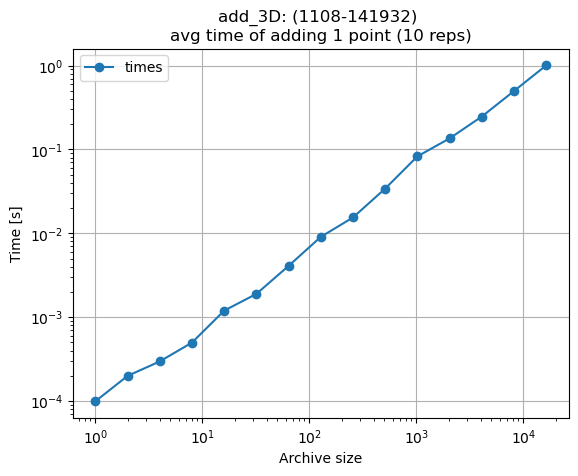

TEST ADD 4
num points | one by one |
         1 | 0.00199509 |
         2 | 0.00299525 |
         4 | 0.00698113 |
         8 | 0.02490091 |
        16 | 0.07579780 |
        32 | 0.20847130 |
        64 | 0.86468720 |
       128 | 2.86537409 |
       256 | 9.21735930 |
       512 | 32.25377274 |
        times
1    0.000200
2    0.000300
4    0.000698
8    0.002490
16   0.007580
32   0.020847
64   0.086469
128  0.286537
256  0.921736
512  3.225377


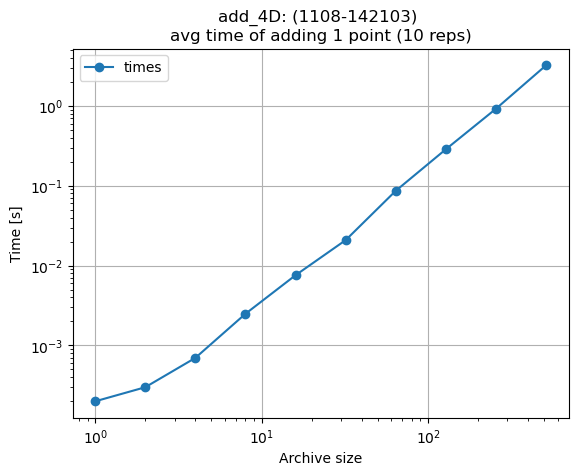

In [7]:

test_add(test_archive_sizes=archive_sizes, n_dim=3, time_limit=10)
plot_performance(plot_function="add_3D", title="avg time of adding 1 point (10 reps)")

test_add(test_archive_sizes=archive_sizes, n_dim=4, time_limit=10)
plot_performance(plot_function="add_4D", title="avg time of adding 1 point (10 reps)")


# Compare the time of adding different amount of points to the archive

In [8]:
def test_add_n_points(test_archive_sizes, test_n_points, n_dim=3, time_limit=10):
    ref_point = [1] * n_dim

    times_one_by_one = {
        n_points: [] for n_points in test_n_points
    }
    times_reinitialize = {
        n_points: [] for n_points in test_n_points
    }
    times_compare = {
        n_points: [] for n_points in test_n_points
    }
    archive_sizes_tested = []
    print("TEST ADD N POINTS", n_dim)
    print(f"{'num points':10} | {'one by one':10} | {'reinit':10} |")

    for archive_size in test_archive_sizes:
        for n_points in test_n_points:
            points = get_non_dominated_points(archive_size, n_dim=n_dim)

            moa_one_by_one = get_archive(copy.deepcopy(points), ref_point, n_obj=n_dim)
            moa_reinitialize = get_archive(copy.deepcopy(points), ref_point, n_obj=n_dim)
            moa_compare = get_archive(copy.deepcopy(points), ref_point, n_obj=n_dim)

            add_points = get_non_dominated_points(n_points, n_dim=n_dim)

            t0 = time.time()
            moa_one_by_one.add_list(add_points, add_method="one_by_one")
            t1 = time.time()
            moa_reinitialize.add_list(add_points, add_method="reinit")
            t2 = time.time()
            moa_compare.add_list(add_points)
            t3 = time.time()

            times_one_by_one[n_points].append(max(t1 - t0, 10e-4))
            times_reinitialize[n_points].append(max(t2 - t1, 10e-4))
            times_compare[n_points].append(max(t3 - t2, 10e-4))

        archive_sizes_tested.append(archive_size)
        print(f"{archive_size:10} | {times_one_by_one[test_n_points[-1]][-1]:.8f} | "
              f"{times_reinitialize[test_n_points[-1]][-1]:.8f} |")
        if (times_one_by_one[test_n_points[-1]][-1] > time_limit or
                times_reinitialize[test_n_points[-1]][-1] > time_limit or
                times_compare[test_n_points[-1]][-1] > time_limit):
            print("TIME LIMIT REACHED")
            break

    data = {}
    for n_points in test_n_points:
        data[f"one_by_one_{n_points}"] = times_one_by_one[n_points]
        data[f"reinitialize_{n_points}"] = times_reinitialize[n_points]
        data[f"compare_{n_points}"] = times_compare[n_points]

    save_results(data=data, index=archive_sizes_tested, n_dim=n_dim, function="add_n_points")


TEST ADD N POINTS 3
num points | one by one | reinit     |
         1 | 0.02792597 | 0.00897670 |
         2 | 0.02892137 | 0.00900364 |
         4 | 0.02692223 | 0.00798059 |
         8 | 0.02795672 | 0.00797868 |
        16 | 0.03291202 | 0.00897598 |
        32 | 0.03786588 | 0.01097059 |
        64 | 0.05182934 | 0.01399446 |
       128 | 0.09378386 | 0.01794600 |
       256 | 0.12566733 | 0.02792645 |
       512 | 0.22439814 | 0.04886985 |
      1024 | 0.44577503 | 0.08680439 |
      2048 | 1.19879913 | 0.17153740 |
      4096 | 1.69646478 | 0.34404755 |
      8192 | 3.62327814 | 0.78293991 |
     16384 | 7.32242417 | 1.37332892 |
     32768 | 14.85229278 | 3.24831676 |
     65536 | 31.17263436 | 6.81082678 |
    131072 | 64.76726532 | 15.40234733 |
TIME LIMIT REACHED
        one_by_one_1  reinitialize_1  compare_1  one_by_one_10  \
1           0.001027        0.001000   0.001000       0.001996   
2           0.001000        0.001000   0.001000       0.001000   
4           0.0010

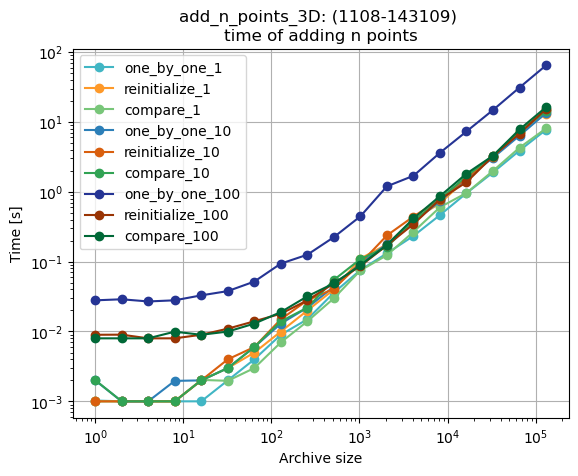

In [9]:
test_add_n_points(test_archive_sizes=archive_sizes, test_n_points=[1, 10, 100],
                  n_dim=3, time_limit=60)
plot_performance(plot_function=f"add_n_points_3D", 
                 colors=['#41b6c4', '#fe9929', '#78c679', '#2c7fb8', '#d95f0e', '#31a354', '#253494', '#993404', '#006837'],
                 title=f"time of adding n points")

In [10]:
def test_kink_points(test_archive_sizes, n_dim=3, time_limit=10):
    print("TEST KINK POINTS")
    times = {
        "spherical": [],
        "linear": [],
    }
    archive_sizes_tested = []
    for archive_size in test_archive_sizes:
        # read the data points and the reference point from the file
        moa = {
            "spherical": get_archive(get_non_dominated_points(archive_size, mode="spherical", n_dim=n_dim), [1] * n_dim),
            "linear": get_archive(get_non_dominated_points(archive_size, mode="linear", n_dim=n_dim), [1] * n_dim),
        }
        t0 = time.time()
        moa["spherical"]._get_kink_points()
        
        t1 = time.time()
        moa["linear"]._get_kink_points()
        t2 = time.time()

        times[f"spherical"].append(max(t1 - t0, 10e-5))
        times[f"linear"].append(max(t2 - t1, 10e-5))
        archive_sizes_tested.append(archive_size)
        print(f"{archive_size:10} | {t2-t1:.8f} |")

        if times[f"spherical"][-1] > time_limit or times[f"linear"][-1] > time_limit:
            break
    
    save_results(data=times, index=archive_sizes_tested, n_dim=n_dim, function="kink_points")


TEST KINK POINTS
         1 | 0.00000000 |
         2 | 0.00000000 |
         4 | 0.00000000 |
         8 | 0.00099730 |
        16 | 0.00099754 |
        32 | 0.00199318 |
        64 | 0.00498676 |
       128 | 0.00897598 |
       256 | 0.01994658 |
       512 | 0.04288530 |
      1024 | 0.09078646 |
      2048 | 0.21753621 |
      4096 | 0.37357616 |
      8192 | 2.10345912 |
     16384 | 1.57338166 |
     32768 | 3.51110530 |
     65536 | 7.25808287 |
    131072 | 14.25208950 |
        spherical     linear
1        0.000100   0.000100
2        0.000100   0.000100
4        0.000100   0.000100
8        0.000100   0.000997
16       0.001996   0.000998
32       0.002994   0.001993
64       0.005984   0.004987
128      0.010971   0.008976
256      0.024934   0.019947
512      0.047084   0.042885
1024     0.147573   0.090786
2048     0.326980   0.217536
4096     0.421515   0.373576
8192     1.078613   2.103459
16384    1.841160   1.573382
32768    3.790015   3.511105
65536    6.900034   7

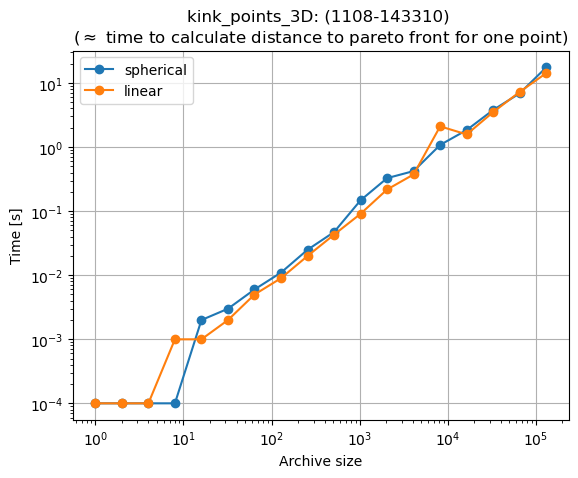

TEST KINK POINTS
         1 | 0.00099802 |
         2 | 0.00350261 |
         4 | 0.00498676 |
         8 | 0.01595211 |
        16 | 0.07081008 |
        32 | 0.38164210 |
        64 | 1.25733852 |
       128 | 5.12831759 |
       256 | 18.69654107 |
     spherical     linear
1     0.000997   0.000998
2     0.003988   0.003503
4     0.004986   0.004987
8     0.016948   0.015952
16    0.055861   0.070810
32    0.438794   0.381642
64    1.242730   1.257339
128   6.948842   5.128318
256  17.889505  18.696541


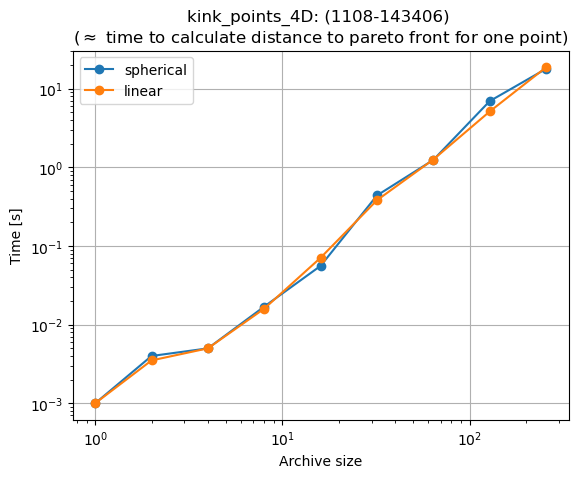

In [11]:
test_kink_points(archive_sizes, n_dim=3, time_limit=10)
plot_performance(plot_function="kink_points_3D", poly_degree=1,
                 title=r"($\approx$ time to calculate distance to pareto front for one point)")

test_kink_points(archive_sizes, n_dim=4, time_limit=10)
plot_performance(plot_function="kink_points_4D", poly_degree=2,
                 title=r"($\approx$ time to calculate distance to pareto front for one point)")


In [12]:
def test_lexsort(test_archive_sizes, n_dim=3):
    time_np = []
    time_my = []

    print("TEST LEXSORT")
    print(f"{'num points':10} | {'my lexsort':10} | {'np lexsort':10} |")
    for n in test_archive_sizes:
        pts = np.random.rand(n, n_dim)
        t0 = time.time()
        my_lexsort([pts[:, i] for i in range(n_dim)])
        t1 = time.time()
        np.lexsort([pts[:, i] for i in range(n_dim)])
        t2 = time.time()

        time_my.append(max(t1 - t0, 10e-5))
        time_np.append(max(t2 - t1, 10e-5))
        print(f"{n:10} | {t1-t0:.8f} | {t2-t1:.8f} |")
    
    save_results(data={"my_lexsort": time_my, "np_lexsort": time_np},
                 index=test_archive_sizes, n_dim=n_dim, function="lexsort")

TEST LEXSORT
num points | my lexsort | np lexsort |
         1 | 0.00000000 | 0.00000000 |
         2 | 0.00000000 | 0.00000000 |
         4 | 0.00000000 | 0.00000000 |
         8 | 0.00000000 | 0.00000000 |
        16 | 0.00000000 | 0.00000000 |
        32 | 0.00000000 | 0.00000000 |
        64 | 0.00099707 | 0.00000000 |
       128 | 0.00000000 | 0.00000000 |
       256 | 0.00099659 | 0.00000000 |
       512 | 0.00102544 | 0.00000000 |
      1024 | 0.00196981 | 0.00000000 |
      2048 | 0.00501060 | 0.00000000 |
      4096 | 0.01193905 | 0.00099730 |
      8192 | 1.45081806 | 0.00099516 |
     16384 | 0.03641343 | 0.00299120 |
     32768 | 0.11973810 | 0.00798202 |
     65536 | 0.21699595 | 0.01698780 |
    131072 | 0.50323176 | 0.03686905 |
    262144 | 0.99898672 | 0.07886100 |
    524288 | 2.27566075 | 0.17307568 |
   1048576 | 4.45363331 | 0.43882585 |
         my_lexsort  np_lexsort
1          0.000100    0.000100
2          0.000100    0.000100
4          0.000100    0.000100
8

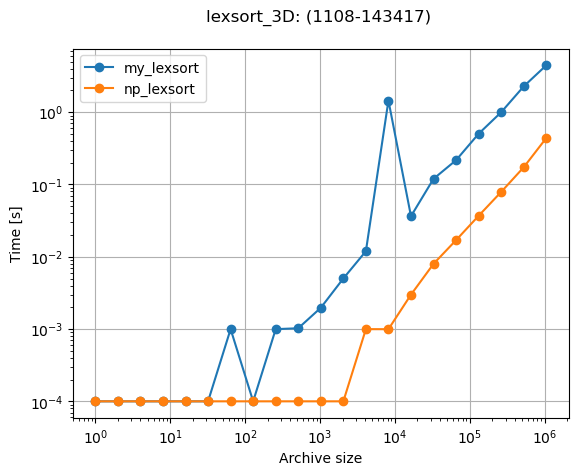

TEST LEXSORT
num points | my lexsort | np lexsort |
         1 | 0.00000000 | 0.00000000 |
         2 | 0.00000000 | 0.00000000 |
         4 | 0.00000000 | 0.00000000 |
         8 | 0.00000000 | 0.00000000 |
        16 | 0.00000000 | 0.00000000 |
        32 | 0.00000000 | 0.00000000 |
        64 | 0.00000000 | 0.00000000 |
       128 | 0.00099802 | 0.00000000 |
       256 | 0.00000000 | 0.00000000 |
       512 | 0.00096822 | 0.00000000 |
      1024 | 0.00199461 | 0.00000000 |
      2048 | 0.00202489 | 0.00099802 |
      4096 | 0.00598145 | 0.00099897 |
      8192 | 0.01695442 | 0.00196481 |
     16384 | 0.02593040 | 0.00498676 |
     32768 | 0.06682229 | 0.00900841 |
     65536 | 0.21439147 | 0.02296662 |
    131072 | 0.55431390 | 0.04989839 |
    262144 | 1.13046265 | 0.10671735 |
    524288 | 2.21899748 | 0.23591065 |
   1048576 | 4.62269163 | 0.58814073 |
         my_lexsort  np_lexsort
1          0.000100    0.000100
2          0.000100    0.000100
4          0.000100    0.000100
8

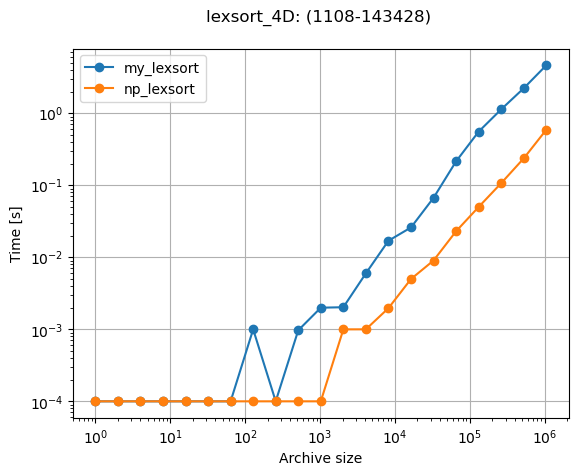

In [13]:
test_lexsort(archive_sizes, n_dim=3)
plot_performance(plot_function="lexsort_3D")

test_lexsort(archive_sizes, n_dim=4)
plot_performance(plot_function="lexsort_4D")

## Contributing hypervolume

In [14]:
def test_contributing_hypervolume(test_archive_sizes, n_dim=3, n_reps=10, time_limit=10):
    times = {
        "naive_spherical": [],
        "naive_linear": []
    }

    print("TEST CONTRIBUTING HYPERVOLUME")
    archive_sizes_tested = []
    for n_points_archive in test_archive_sizes:
        points = {
            "spherical": get_non_dominated_points(n_points_archive, mode="spherical", n_dim=n_dim),
            "linear": get_non_dominated_points(n_points_archive, mode="linear", n_dim=n_dim),
        }
        moa = {
            "spherical": get_archive(points["spherical"], [1] * n_dim),
            "linear": get_archive(points["linear"], [1] * n_dim),
        }
        
        t0 = time.time()
        _ = [moa["spherical"].contributing_hypervolume(p) for p in points["spherical"]]
        t1 = time.time()
        _ = [moa["linear"].contributing_hypervolume(p) for p in points["linear"]]
        t2 = time.time()
        
        times["naive_spherical"].append(max((t1 - t0) / n_reps, 10e-5))
        times["naive_linear"].append(max((t2 - t1) / n_reps, 10e-5))
        archive_sizes_tested.append(n_points_archive)

        print(f"{n_points_archive:10} | {times[f'naive_spherical'][-1]:.8f} | {times[f'naive_linear'][-1]:.8f} |")
        if t1 - t0 > time_limit or t2 - t1 > time_limit:
            break
    
    save_results(data=times, index=archive_sizes_tested, n_dim=n_dim, function="contributing_hypervolume")


TEST CONTRIBUTING HYPERVOLUME
         1 | 0.00010000 | 0.00010000 |
         2 | 0.00010000 | 0.00010000 |
         4 | 0.00010000 | 0.00010000 |
         8 | 0.00090051 | 0.00069530 |
        16 | 0.00318973 | 0.00319049 |
        32 | 0.01226766 | 0.01216733 |
        64 | 0.05381629 | 0.04996684 |
       128 | 0.21627698 | 0.20243373 |
       256 | 0.94794705 | 0.89762549 |
       512 | 4.43274398 | 4.09775674 |
     naive_spherical  naive_linear
1           0.000100      0.000100
2           0.000100      0.000100
4           0.000100      0.000100
8           0.000901      0.000695
16          0.003190      0.003190
32          0.012268      0.012167
64          0.053816      0.049967
128         0.216277      0.202434
256         0.947947      0.897625
512         4.432744      4.097757


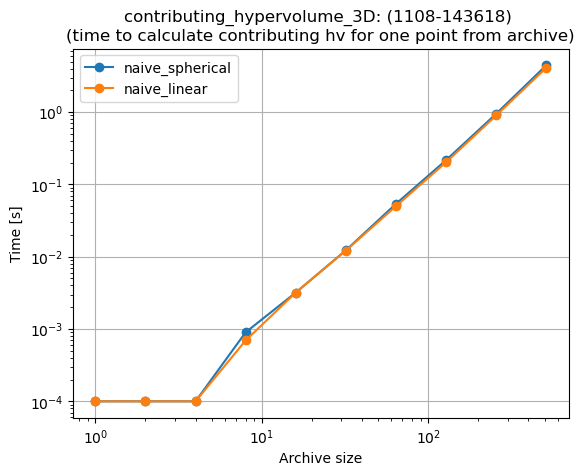

TEST CONTRIBUTING HYPERVOLUME
         1 | 0.00010000 | 0.00010000 |
         2 | 0.00010000 | 0.00010000 |
         4 | 0.00029910 | 0.00029922 |
         8 | 0.00269566 | 0.00249350 |
        16 | 0.01865027 | 0.01625967 |
        32 | 0.12831581 | 0.12813215 |
        64 | 0.96860228 | 1.03965461 |
    naive_spherical  naive_linear
1          0.000100      0.000100
2          0.000100      0.000100
4          0.000299      0.000299
8          0.002696      0.002494
16         0.018650      0.016260
32         0.128316      0.128132
64         0.968602      1.039655


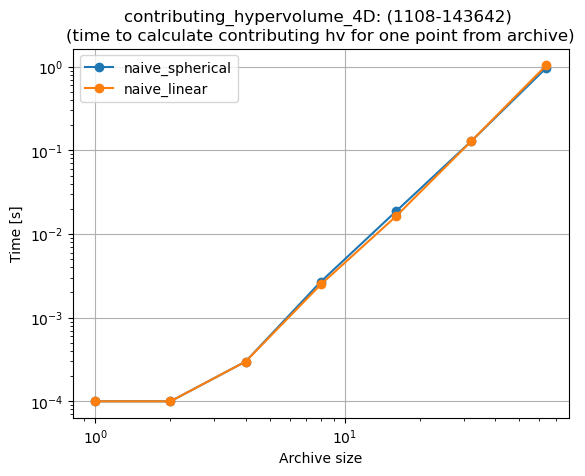

In [15]:
test_contributing_hypervolume(archive_sizes, n_dim=3, time_limit=10)
plot_performance(plot_function="contributing_hypervolume_3D",
                 title="(time to calculate contributing hv for one point from archive)")

test_contributing_hypervolume(archive_sizes, n_dim=4, time_limit=10)
plot_performance(plot_function="contributing_hypervolume_4D",
                 title="(time to calculate contributing hv for one point from archive)")

## Hypervolume improvement

In [16]:
def test_hypervolume_improvement(test_archive_sizes, time_limit=10, n_dim=3, n_reps=10):

    print("TEST HYPERVOLUME IMPROVEMENT")
    times = {
        "times_spherical": [],
        "times_linear": [],
    }
    archive_sizes_tested = []
    for n_points_archive in test_archive_sizes:
        moa = {
            "spherical": get_archive(get_non_dominated_points(n_points_archive, mode="spherical", n_dim=n_dim), [1] * n_dim),
            "linear": get_archive(get_non_dominated_points(n_points_archive, mode="linear", n_dim=n_dim), [1] * n_dim)
        }
        new_points = {
            "spherical": get_non_dominated_points(n_reps, mode="spherical", n_dim=n_dim),
            "linear": get_non_dominated_points(n_reps, mode="linear", n_dim=n_dim)
        }
                
        t0 = time.time()
        _ = [moa["spherical"].hypervolume_improvement(p) for p in new_points["spherical"]]
        t1 = time.time()
        _ = [moa["linear"].hypervolume_improvement(p) for p in new_points["linear"]]
        t2 = time.time()

        times["times_spherical"].append(max((t1 - t0) / n_reps, 10e-5))
        times[f"times_linear"].append(max((t2 - t1) / n_reps, 10e-5))
        archive_sizes_tested.append(n_points_archive)
                
        print(f"{n_points_archive:10} | {times['times_spherical'][-1]:.8f} | {times['times_linear'][-1]:.8f} |")

        if t1 - t0 > time_limit or t2 - t1 > time_limit:
            break
    
    save_results(data=times, index=archive_sizes_tested, n_dim=n_dim, function="hypervolume_improvement")

TEST HYPERVOLUME IMPROVEMENT
         1 | 0.00010276 | 0.00010000 |
         2 | 0.00010000 | 0.00010000 |
         4 | 0.00010000 | 0.00010000 |
         8 | 0.00010000 | 0.00010000 |
        16 | 0.00010000 | 0.00020177 |
        32 | 0.00019944 | 0.00019946 |
        64 | 0.00019948 | 0.00029922 |
       128 | 0.00039892 | 0.00039892 |
       256 | 0.00079460 | 0.00049863 |
       512 | 0.00090103 | 0.00129638 |
      1024 | 0.00239320 | 0.00199528 |
      2048 | 0.00379267 | 0.00588148 |
      4096 | 0.00907571 | 0.00578165 |
      8192 | 0.02483025 | 0.01596096 |
     16384 | 0.07549586 | 0.05136592 |
     32768 | 0.13120966 | 0.09983072 |
     65536 | 0.29003451 | 0.27567017 |
    131072 | 0.59577627 | 0.55335472 |
    262144 | 1.27855306 | 1.06339455 |
        times_spherical  times_linear
1              0.000103      0.000100
2              0.000100      0.000100
4              0.000100      0.000100
8              0.000100      0.000100
16             0.000100      0.000202
32

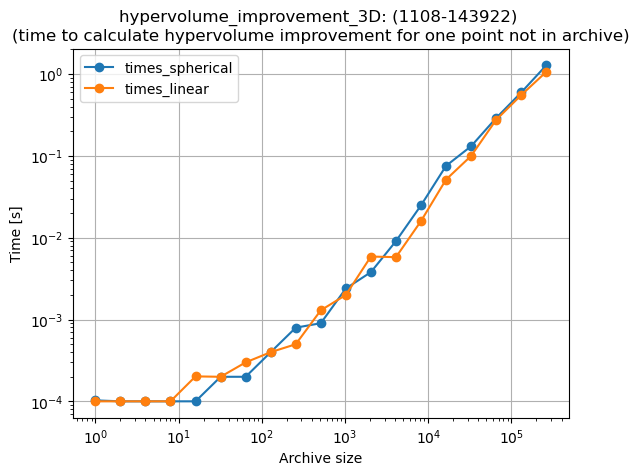

TEST HYPERVOLUME IMPROVEMENT
         1 | 0.00049863 | 0.00029922 |
         2 | 0.00049858 | 0.00039895 |
         4 | 0.00149608 | 0.00139942 |
         8 | 0.00309169 | 0.00329127 |
        16 | 0.01306500 | 0.01412599 |
        32 | 0.05345707 | 0.04999714 |
        64 | 0.14837022 | 0.13933225 |
       128 | 0.54655023 | 0.53463714 |
       256 | 1.65283594 | 1.76445205 |
     times_spherical  times_linear
1           0.000499      0.000299
2           0.000499      0.000399
4           0.001496      0.001399
8           0.003092      0.003291
16          0.013065      0.014126
32          0.053457      0.049997
64          0.148370      0.139332
128         0.546550      0.534637
256         1.652836      1.764452


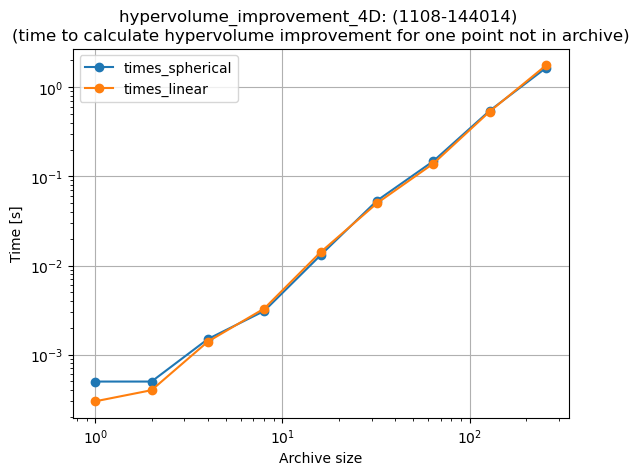

In [17]:
test_hypervolume_improvement(archive_sizes, time_limit=10, n_dim=3)
plot_performance(plot_function="hypervolume_improvement_3D",
                 title="(time to calculate hypervolume improvement for one point not in archive)")

test_hypervolume_improvement(archive_sizes, time_limit=10, n_dim=4)
plot_performance(plot_function="hypervolume_improvement_4D",
                 title="(time to calculate hypervolume improvement for one point not in archive)")